# Cluster Module

The cluster module uses a set of coordinates and a cutoff distance to determine clustered points. The example below generates random points, and shows that they form clusters. This case is two-dimensional (with z=0 for all particles) for simplicity, but the cluster module works for both 2D and 3D simulations.

In [2]:
import numpy as np
import freud
import matplotlib.pyplot as plt

First, we generate random points to cluster.

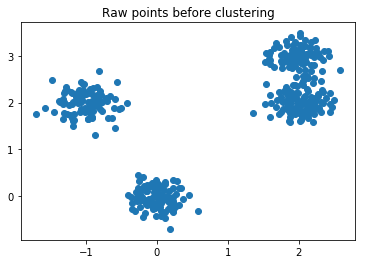

In [3]:
points = np.empty(shape=(0, 2))
for center_point in [(0, 0), (2, 2), (-1, 2), (2, 3)]:
    points = np.concatenate(
        (points, np.random.multivariate_normal(mean=center_point, cov=0.05*np.eye(2), size=(100,))))
plt.scatter(points[:,0], points[:,1])
plt.title('Raw points before clustering')
plt.show()

# We must add a z=0 component to this array for freud
points = np.hstack((points, np.zeros((points.shape[0], 1))))

Now we create a box and a cluster compute object.

In [4]:
box = freud.box.Box.square(L=10)
cl = freud.cluster.Cluster(box=box, rcut=1.0)

ValueError: 3D boxes must have nonzero lengths.

Next, we use the `computeClusters` method to determine clusters and the `clusterIdx` property to return their identities. Note that we use `freud`'s *method chaining* here, where a compute method returns the compute object.

In [ ]:
cluster_idx = cl.computeClusters(points).cluster_idx
print(cluster_idx)

In [ ]:
for cluster_id in range(cl.num_clusters):
    cluster_point_indices = np.where(cluster_idx == cluster_id)[0]
    plt.scatter(points[cluster_point_indices, 0], points[cluster_point_indices, 1], label="Cluster {}".format(cluster_id))
    print("There are {} points in cluster {}.".format(len(cluster_point_indices), cluster_id))
plt.title('Clusters identified')
plt.legend(loc='best')
plt.show()

We may also compute the clusters' centers of mass and gyration tensor using the `ClusterProperties` class.

In [6]:
clp = freud.cluster.ClusterProperties(box=box)
clp.computeProperties(points, cl.cluster_idx)

Plotting these clusters with their centers of mass, with size proportional to the number of clustered points:

In [1]:
plt.figure(figsize=(9, 6))
for cluster_id in range(cl.num_clusters):
    cluster_point_indices = np.where(cluster_idx == cluster_id)[0]
    plt.scatter(points[cluster_point_indices, 0], points[cluster_point_indices, 1], label="Cluster {}".format(cluster_id))
for cluster_id in range(cl.num_clusters):
    cluster_point_indices = np.where(cluster_idx == cluster_id)[0]
    plt.scatter(clp.cluster_COM[cluster_id, 0], clp.cluster_COM[cluster_id, 1], s=len(cluster_point_indices), label="Cluster {} COM".format(cluster_id))
plt.title('Center of mass for each cluster')
plt.legend(loc='best')
plt.show()

NameError: name 'plt' is not defined

The clusters' 3x3 gyration tensor $G$ can also be computed. For this two-dimensional case, the $z$ components of the gyration tensor are zero.

In [8]:
for cluster_id in range(cl.num_clusters):
    G = clp.cluster_G[cluster_id]
    print("The gyration tensor of cluster {} is:\n{}".format(cluster_id, G))

The gyration tensor of cluster 0 is:
[[0.0480928  0.00478933 0.        ]
 [0.00478933 0.05940801 0.        ]
 [0.         0.         0.        ]]
The gyration tensor of cluster 1 is:
[[ 0.03997406 -0.00352212  0.        ]
 [-0.00352212  0.31749186  0.        ]
 [ 0.          0.          0.        ]]
The gyration tensor of cluster 2 is:
[[0.04243931 0.00176673 0.        ]
 [0.00176673 0.05135175 0.        ]
 [0.         0.         0.        ]]


This gyration tensor can be used to determine the principal axes of the cluster and radius of gyration along each principal axis. Here, we plot the gyration tensor's eigenvectors with length corresponding to the square root of the eigenvalues (the singular values).

Cluster 0 has radius of gyration 0.0463 along the axis of (-0.9389, -0.3441).
Cluster 0 has radius of gyration 0.0612 along the axis of (0.3441, -0.9389).
Cluster 1 has radius of gyration 0.0399 along the axis of (-0.9999, 0.0127).
Cluster 1 has radius of gyration 0.3175 along the axis of (-0.0127, -0.9999).
Cluster 2 has radius of gyration 0.0421 along the axis of (-0.9822, -0.1876).
Cluster 2 has radius of gyration 0.0517 along the axis of (0.1876, -0.9822).


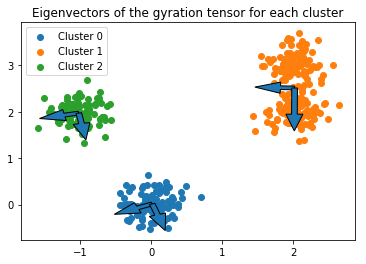

In [9]:
for cluster_id in range(cl.num_clusters):
    cluster_point_indices = np.where(cluster_idx == cluster_id)[0]
    plt.scatter(points[cluster_point_indices, 0], points[cluster_point_indices, 1], label="Cluster {}".format(cluster_id))
for cluster_id in range(cl.num_clusters):
    com = clp.cluster_COM[cluster_id]
    G = clp.cluster_G[cluster_id]
    evals, evecs = np.linalg.eig(G)
    radii = np.sqrt(evals)
    for evalue, evec in zip(evals[:2], evecs[:2, :2]):
        print("Cluster {} has radius of gyration {:.4f} along the axis of ({:.4f}, {:.4f}).".format(cluster_id, evalue, *evec))
    arrows = (radii * evecs)[:2, :2]
    for arrow in arrows:
        plt.arrow(com[0], com[1], arrow[0], arrow[1], width=0.08)
plt.title('Eigenvectors of the gyration tensor for each cluster')
plt.legend(loc='best')
plt.show()